In [1]:
import pandas as pd
import random as rd
from collections import Counter
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def generate_random_solution(df):
    category = df.category.values.tolist()
    np.random.shuffle(category)
    category_copy = category.copy()
    hard_constrait = []
    for cand in category_copy:
        if cand == 'Ht' or cand == 'St':
            hard_constrait.append(cand)
            category.remove(cand)

    empty_space = total - len(hard_constrait)

    soft_constrait = []
    for cand in range(empty_space):
        soft_constrait.append(np.random.choice(category))

    solution = hard_constrait + soft_constrait
    
    return solution, hard_constrait, category

In [3]:
def evaluate_solution(solution, weight):
    frequency = Counter(solution)
    loss = 0
    for category in solution: loss += weight[category] * frequency[category]
    return loss

In [4]:
def levyFlight(empty_space, category):
    """this will allow us jump over long distances 10% of the time and ...
    add all the next seven categories in front as the short distance search"""
    soft_constrait = []
    while len(soft_constrait) <= empty_space:
        choice_idx = np.random.choice(empty_space)
        picker = np.random.choice(np.linspace(0.1, 0.7, 7)) #levy flight location probability constrait
        if picker*total < choice_idx <= (picker+0.1)*total:
            soft_constrait += category[choice_idx:choice_idx+7]
        else: soft_constrait.append(category[choice_idx])
    soft_constrait = soft_constrait[:empty_space]
    return soft_constrait

In [5]:
def mutate_solution(hard_constrait, category):
#   mutate the solution by generating new soft constrait solution
    empty_space = total - len(hard_constrait)

    soft_constrait = levyFlight(empty_space, category)
    solution = hard_constrait + soft_constrait    
    return solution

In [6]:
def check_tabu(tabu, solution):
    tenure = 0
    while solution in tabu.values() and tenure < tabu_tenure:
        solution  = mutate_solution(hard_sol, new_category)
        tenure += 1
    
    cost = evaluate_solution(solution, weight)
        
    tabu_copy = tabu.copy()
    for val in tabu.keys():
        if cost > val:
            del tabu_copy[val]
            tabu_copy[cost] = solution
            
    return solution, cost, tabu_copy

In [7]:
def cuckoo_tabu_CA(df, num_itr = 200, num_nests = 4, tabu_length = 2, tabu_tenure = 50):
    start_time = time.time()
    
    record = {}
#     initialize tabu_list
    tabu_list = {}
#     create nests and insert one solution in each
    nests = { }
    for nest in range(num_nests):
        solution = generate_random_solution(df)
        new_category = solution[-1].copy()
        
        tabu_tenure_c = 0
        while solution[0] in tabu_list.values() and tabu_tenure_c < tabu_tenure:            
            solution = generate_random_solution(df)
            tabu_tenure += 1

        cost = evaluate_solution(solution[0], weight)

        # check if generated solution is in tabu_list
        if len(tabu_list) < tabu_length: tabu_list[cost] = solution[0] #add to tabu
            
        solution = list(solution[:-1])
        solution.append(cost)
        nests[nest] = solution #add to nests
        
#     create a cuckoo solution
    cuckoo_solution, hard_sol, _ = nests[0]
    cuckoo_solution = mutate_solution(hard_sol, new_category)
    cuckoo_solution, cost, tabu_list = check_tabu(tabu_list, cuckoo_solution)
    record[0] = cost
    
    idx_c_nest = np.random.choice(list(nests.keys()))
    if cost > nests[idx_c_nest][-1]:
        nests[idx_c_nest] = (cuckoo_solution, hard_sol, cost)
        print("Iteration 0.... cuckoo solution replaces solution at nest {} with cost {}".format(idx_c_nest+1, cost))
        
    for itr in range(num_itr):
        cuckoo_solution = mutate_solution(hard_sol, new_category)
        cuckoo_solution, cost, tabu_list = check_tabu(tabu_list, cuckoo_solution)
        
        idx_c_nest = np.random.choice(list(nests.keys()))
        if cost > nests[idx_c_nest][-1]:
            nests[idx_c_nest] = (cuckoo_solution, hard_sol, cost)
            record[itr] = cost
            print("Iteration {}.... cuckoo solution replaces solution at nest {} with cost {}".format(itr, idx_c_nest+1, cost))
            
#         select the best solution within all nests
    nests = {v[-1]:v[0] for k,v in nests.items()}
    best_cost = min(list(nests.keys()))
    best_solution = nests[best_cost]
    
    end_time = time.time()
    print("\n Time taken - {}seconds".format(end_time-start_time))
    return best_solution, record

In [8]:
def generate_random_solution_HA(CA, HA_stat):
    np.random.shuffle(CA)
    generated = {}
    CA_copy = CA.copy()
    for hall in HA_stat:
        candidates = []
        for count in range(HA_stat[hall]):
            student = np.random.choice(CA_copy)
            candidates.append(student)
            CA_copy.remove(student)
        generated[hall] = candidates
    
    generated = list(generated.values())
    
    matrix_solution = []
    for hall in generated:
        solution = []
        
        frequency = Counter(hall) #count each category in each hall
        for category in order:
            solution.append(frequency[category]) #append count of each category in each hall
        
        matrix_solution.append(solution) # concatenate solutions of all categories in all halls together
    
#     transpose solution to allow rows represent each category and column represent each hall
    matrix_solution = np.array(matrix_solution).transpose()
    return matrix_solution

In [9]:
def evaluate_solution_HA(solution, data):
    solution = {i:j for i,j in zip(data, solution)}
    cost = 0
    for cat in solution: #loop through each category 
        proportion = data[cat] - (max(solution[cat]) - min(solution[cat]))
        N = sum(solution[cat] > 0 ) #number of halls that have some students of i-th category
        cost += proportion * N
    return cost

In [10]:
def levyFlight_HA(empty_space, CA):
    """this will allow us jump over long distances 10% of the time and ...
    add all the next seven categories in front as the short distance search"""
    space = empty_space
    soft_constrait = []
    while len(soft_constrait) < space:
            
        choice_idx = np.random.choice(empty_space)
        picker = np.random.choice(np.linspace(0.1, 0.8, 8))
        
        if picker*empty_space < choice_idx <= ((picker+0.1)*empty_space): #10% probability
            if choice_idx+3 > len(CA) and len(CA) > 3:
                soft_constrait += CA[choice_idx-3:choice_idx]
                del CA[choice_idx-3:choice_idx]
                empty_space -= len(CA[choice_idx-3:choice_idx])
            
            elif len(CA) <= 3:
                soft_constrait += CA[:]
                del CA[:]
                empty_space -= len(CA[:])
                
            else:
                soft_constrait += CA[choice_idx:choice_idx+3]
                del CA[choice_idx:choice_idx+3]
                empty_space -= len(CA[choice_idx:choice_idx+3])
        
        elif choice_idx < len(CA):
            soft_constrait.append(CA[choice_idx-1])
            empty_space -= 1
            CA.remove(CA[choice_idx-1])
            
    CA += soft_constrait[space:]  
    soft_constrait = soft_constrait[:space]

    return soft_constrait, CA

In [11]:
def mutate_solution_HA(CA, HA_stat):
    generated = {}
    CA_copy = CA.copy()
    for hall in HA_stat:
        candidates, CA_copy = levyFlight_HA(HA_stat[hall], CA_copy)
        generated[hall] = candidates        
        
    generated = list(generated.values())
    
    matrix_solution = []
    for hall in generated:
        solution = []
        
        frequency = Counter(hall) #count each category in each hall
        for category in order:
            solution.append(frequency[category]) #append count of each category in each hall
        
        matrix_solution.append(solution) # concatenate solutions of all categories in all halls together
    
#     transpose solution to allow rows represent each category and column represent each hall
    matrix_solution = np.array(matrix_solution).transpose()
    return matrix_solution

In [12]:
def check_tabu_HA(tabu, solution):
    tenure = 0
    while solution.flatten().tolist() in [i.flatten().tolist() for i in tabu.values()] and tenure < tabu_tenure:
        solution  = mutate_solution_HA(best_solution_CA, HA_data)
        tenure += 1
    
    cost = evaluate_solution_HA(solution, best_solution_CA_dict)
        
    tabu_copy = tabu.copy()
    for val in tabu.keys():
        if cost > val:
            del tabu_copy[val]
            tabu_copy[cost] = solution
            
    return solution, cost, tabu_copy

In [13]:
def cuckoo_tabu_HA(df, num_itr = 200, num_nests = 4, tabu_length = 2, tabu_tenure = 50):
    start_time = time.time()

    record = {}
#     initialize tabu_list
    tabu_list = {}
    
#     create nests and insert one solution in each
    nests = { }
    for nest in range(num_nests):
        solution = generate_random_solution_HA(best_solution_CA, HA_data)
        
        tabu_tenure_c = 0
        while solution.flatten().tolist() in [i.flatten().tolist() for i in tabu_list.values()] and tabu_tenure_c < tabu_tenure:            
            solution = generate_random_solution_HA(best_solution_CA, HA_data)
            tabu_tenure_c += 1

        cost = evaluate_solution_HA(solution, best_solution_CA_dict)

        # check if generated solution is in tabu_list
        if len(tabu_list) < tabu_length: tabu_list[cost] = solution #add to tabu
            
        nests[nest] = (solution, cost) #add to nests
        
#     create a cuckoo solution
    cuckoo_solution = mutate_solution_HA(best_solution_CA, HA_data)
    cuckoo_solution, cost, tabu_list = check_tabu_HA(tabu_list, cuckoo_solution)
    record[0] = cost
    idx_c_nest = np.random.choice(list(nests.keys()))
    if cost > nests[idx_c_nest][-1]:
        nests[idx_c_nest] = (cuckoo_solution, cost)
        print("Iteration 0.... cuckoo solution replaces solution at nest {} with cost {}".format(idx_c_nest+1, cost))
        
    for itr in range(num_itr):
        cuckoo_solution = mutate_solution_HA(best_solution_CA, HA_data)
        cuckoo_solution, cost, tabu_list = check_tabu_HA(tabu_list, cuckoo_solution)
            
        idx_c_nest = np.random.choice(list(nests.keys()))
        if cost > nests[idx_c_nest][-1]:
            nests[idx_c_nest] = (cuckoo_solution, cost)
            record[itr] = cost
            print("Iteration {}.... cuckoo solution replaces solution at nest {} with cost {}".format(itr, idx_c_nest+1, cost))
                        
#         select the best solution within all nests
    nests = {v[-1]:v[0] for k,v in nests.items()}
    best_cost = max(list(nests.keys()))
    best_solution = nests[best_cost]
    
    end_time = time.time()
    print("\n Time taken - {}seconds".format(end_time-start_time))
    print(' Best Fitness value -', best_cost)
    return best_solution, record

## **Implementation - Male applicants**

In [14]:
# Read in data
male_df = pd.read_csv('male_applicants.csv')
male_df.head()

,names,category,weight
0,rqtttt,Ot,0.5
1,zhuztd,Ot,0.5
2,hqxfqg,Ot,0.5
3,sanjtt,Fy,0.5
4,mjbgpk,Ot,0.5


In [15]:
#this represents the amount of student that applied for each category
male_data = {'Fy': 1360, 'Fr':1660, 'Ht':60, 'Sp':290, 'St':260, 'Ot':3736} 

#total amount of students that can be taken by all male hostels
total = 2072 

#total amount of students that belong to the soft constrait group
soft_constr_weight = 1368 + 1660 + 290 + 3736 

#weight the population of the soft constrait group based the amount of people that applied
weight = {'Fy': 1 - (1360/soft_constr_weight), 'Fr': 1-(1660/soft_constr_weight), 'Ht':1, 'Sp':1- (290/soft_constr_weight), 'St':1, 'Ot': 1- (3736/soft_constr_weight)}
print(weight)

{'Fy': 0.8072015877516303, 'Fr': 0.7646725262262546, 'Ht': 1, 'Sp': 0.9588885738588036, 'St': 1, 'Ot': 0.47037142047065494}


In [16]:
#amount of students that can be allocated to each male hostel
HA_data = {'Akindeko': 625, 'Abiola':356, 'Adeniyi':195, 'New Male Hostel':792, 'Bisi Balogun':104}
order = ['Fy','Fr','Ht','Sp','St','Ot']

#### **Generate a random solution - Category Allocation (CA): MALE APPLICANTS**

In [17]:
solution, _ , _= generate_random_solution(male_df)
frequency = Counter(solution)

show = pd.DataFrame()
for i in frequency: show[i] = [frequency[i]]
show.head()

,St,Ht,Ot,Fy,Fr,Sp
0,260,60,915,335,433,69


#### **HHybridized Cuckoo_Tabu optimized solution - Category Allocation (CA) MALE APPLICANTS**

In [24]:
best_solution_CA, graph = cuckoo_tabu_CA(male_df)

frequency = Counter(best_solution_CA)

best_solution_CA_dict = {i:j for i,j in frequency.items()}

show = pd.DataFrame()
for i in frequency: show[i] = [frequency[i]]
show.head()

Iteration 0.... cuckoo solution replaces solution at nest 1 with cost 712932.8786504266
Iteration 0.... cuckoo solution replaces solution at nest 3 with cost 716266.8661752259
Iteration 2.... cuckoo solution replaces solution at nest 1 with cost 725157.6932236922
Iteration 3.... cuckoo solution replaces solution at nest 4 with cost 722665.1930819363
Iteration 4.... cuckoo solution replaces solution at nest 2 with cost 723094.3717040122
Iteration 7.... cuckoo solution replaces solution at nest 4 with cost 723104.104054447
Iteration 16.... cuckoo solution replaces solution at nest 3 with cost 725148.798412256
Iteration 21.... cuckoo solution replaces solution at nest 1 with cost 730040.669123886
Iteration 23.... cuckoo solution replaces solution at nest 4 with cost 726012.494754761
Iteration 24.... cuckoo solution replaces solution at nest 4 with cost 727753.3853132811
Iteration 26.... cuckoo solution replaces solution at nest 2 with cost 726939.051034876
Iteration 34.... cuckoo solution

,St,Ht,Ot,Fy,Fr,Sp
0,260,60,985,313,415,39


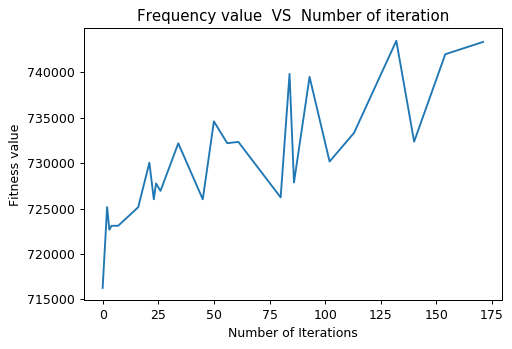

In [25]:
plt.figure(dpi = 90)
plt.title("Frequency value  VS  Number of iteration")
plt.xlabel('Number of Iterations')
plt.ylabel('Fitness value')
plt.plot(list(graph.keys()), list(graph.values()))
plt.show()

#### **Generate a random solution- Hall Allocation (HA) MALE APPLICANTS**

In [26]:
solution_HA = generate_random_solution_HA(best_solution_CA, HA_data)

show = pd.DataFrame(solution_HA,
                    columns = ['Akindeko', 'Abiola', 'Adeniyi', 'New Male Hostel', 'Bisi Balogun'],
                    index = ['Fy','Fr','Ht','Sp','St','Ot'])

show

,Akindeko,Abiola,Adeniyi,New Male Hostel,Bisi Balogun
Fy,97,56,32,114,14
Fr,132,78,35,151,19
Ht,13,9,11,24,3
Sp,14,5,2,17,1
St,70,51,25,104,10
Ot,299,157,90,382,57


#### **Hybridized Cuckoo_Tabu optimized solution- Hall Allocation (HA) MALE APPLICANTS**

In [31]:
result, graph = cuckoo_tabu_HA(200) 
show = pd.DataFrame(result,
                    columns = ['Akindeko', 'Abiola', 'Adeniyi', 'New Male Hostel', 'Bisi Balogun'],
                    index = ['Fy','Fr','Ht','Sp','St','Ot'])

show

Iteration 2.... cuckoo solution replaces solution at nest 4 with cost 6920
Iteration 5.... cuckoo solution replaces solution at nest 1 with cost 6920

 Time taken - 32.932154178619385seconds
 Best Fitness value - 6920


,Akindeko,Abiola,Adeniyi,New Male Hostel,Bisi Balogun
Fy,97,48,29,124,15
Fr,127,62,47,161,18
Ht,22,8,4,22,4
Sp,8,7,5,14,5
St,65,39,28,116,12
Ot,306,192,82,355,50


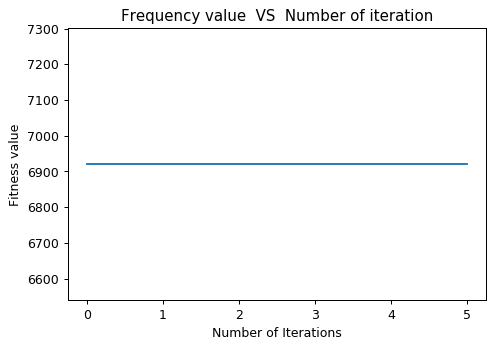

In [32]:
plt.figure(dpi = 90)
plt.title("Frequency value  VS  Number of iteration")
plt.xlabel('Number of Iterations')
plt.ylabel('Fitness value')
plt.plot(list(graph.keys()), list(graph.values()))
plt.show()

## **Implementation - Female applicants**

In [33]:
# Read in data
female_df = pd.read_csv('female_applicants.csv')
female_df.head()

,names,category
0,ymguns,Fy
1,xhvcdk,Fy
2,vdnszo,Ot
3,vbcnxs,Ot
4,wcdduo,Ot


In [34]:
#this represents the amount of student that applied for each category
female_data = {'Fy': 820, 'Fr':958, 'Ht':56, 'Sp':80, 'St':100, 'Ot':1120} 

#total amount of students that can be taken by all female hostels
total = 1593

#total amount of students that belong to the soft constrait group
soft_constr_weight = 820 + 958 + 80 + 1120 

#weight the population of the soft constrait group based the amount of people that applied
weight = {'Fy': 1 - (820/soft_constr_weight), 'Fr': 1-(958/soft_constr_weight), 'Ht':1, 'Sp':1- (80/soft_constr_weight), 'St':1, 'Ot': 1- (1120/soft_constr_weight)}
print(weight)

{'Fy': 0.7246474143720618, 'Fr': 0.6783075889858965, 'Ht': 1, 'Sp': 0.9731363331094695, 'St': 1, 'Ot': 0.6239086635325721}


In [35]:
#amount of students that can be allocated to each male hostel
HA_data = {'New Female Hostel': 792, 'Jadesola':229, 'Jibowu(Main)':332, 'Jibowu Annex 1':80, 'Jibowu Annex 2':80,'Jibowu Annex 3':80}
order = ['Fy','Fr','Ht','Sp','St','Ot']

#### **Generate a random solution - Category Allocation (CA): FEMALE APPLICANTS**

In [36]:
solution, _ , _= generate_random_solution(female_df)
frequency = Counter(solution)

show = pd.DataFrame()
for i in frequency: show[i] = [frequency[i]]
show.head()

,Ht,St,Ot,Sp,Fr,Fy
0,56,100,547,33,456,401


#### **Hybridized Cuckoo_Tabu optimized solution - Category Allocation (CA) FEMALE APPLICANTS**

In [39]:
best_solution_CA, graph = cuckoo_tabu_CA(female_df)

frequency = Counter(best_solution_CA)

best_solution_CA_dict = {i:j for i,j in frequency.items()}

show = pd.DataFrame()
for i in frequency: show[i] = [frequency[i]]
show.head()

Iteration 0.... cuckoo solution replaces solution at nest 3 with cost 454067.4775016873
Iteration 0.... cuckoo solution replaces solution at nest 2 with cost 461487.550033578
Iteration 1.... cuckoo solution replaces solution at nest 3 with cost 461247.4022834057
Iteration 2.... cuckoo solution replaces solution at nest 1 with cost 467429.5204835469
Iteration 3.... cuckoo solution replaces solution at nest 3 with cost 464764.1282740129
Iteration 4.... cuckoo solution replaces solution at nest 2 with cost 462197.4479516525
Iteration 5.... cuckoo solution replaces solution at nest 4 with cost 464257.5513767724
Iteration 14.... cuckoo solution replaces solution at nest 2 with cost 463777.2955003379
Iteration 38.... cuckoo solution replaces solution at nest 4 with cost 466798.5413028922
Iteration 41.... cuckoo solution replaces solution at nest 3 with cost 464831.0879784985
Iteration 74.... cuckoo solution replaces solution at nest 3 with cost 466366.8509066509
Iteration 78.... cuckoo solut

,St,Ht,Ot,Sp,Fy,Fr
0,100,56,556,31,344,506


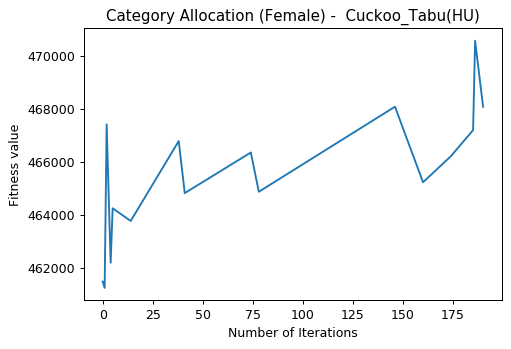

In [40]:
plt.figure(dpi = 90)
plt.title("Category Allocation (Female) -  Cuckoo_Tabu(HU)")
plt.xlabel('Number of Iterations')
plt.ylabel('Fitness value')
plt.plot(list(graph.keys()), list(graph.values()))
plt.show()

#### **Hybridized Cuckoo_Tabu optimized solution- Hall Allocation (HA) FEMALE APPLICANTS**

In [43]:
result, graph = cuckoo_tabu_HA(200) 
show = pd.DataFrame(result,
                    columns = ['New Female Hostel', 'Jadesola', 'Jibowu(Main)', 'Jibowu Annex 1', 'Jibowu Annex 2','Jibowu Annex 3'],
                    index = ['Fy','Fr','Ht','Sp','St','Ot'])

show

Iteration 1.... cuckoo solution replaces solution at nest 3 with cost 5190
Iteration 5.... cuckoo solution replaces solution at nest 3 with cost 5202
Iteration 9.... cuckoo solution replaces solution at nest 4 with cost 5202
Iteration 12.... cuckoo solution replaces solution at nest 1 with cost 5220
Iteration 17.... cuckoo solution replaces solution at nest 3 with cost 5232
Iteration 26.... cuckoo solution replaces solution at nest 4 with cost 5208
Iteration 30.... cuckoo solution replaces solution at nest 4 with cost 5226
Iteration 43.... cuckoo solution replaces solution at nest 2 with cost 5226

 Time taken - 26.0325288772583seconds
 Best Fitness value - 5232


,New Female Hostel,Jadesola,Jibowu(Main),Jibowu Annex 1,Jibowu Annex 2,Jibowu Annex 3
Fy,176,55,71,17,15,10
Fr,233,81,101,28,31,32
Ht,25,8,14,3,3,3
Sp,17,5,4,3,1,1
St,52,11,24,4,4,5
Ot,289,69,118,25,26,29


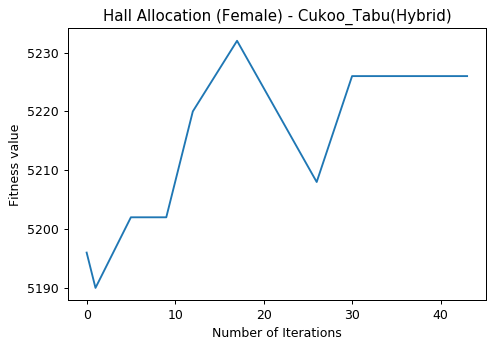

In [45]:
plt.figure(dpi = 90)
plt.title("Hall Allocation (Female) - Cukoo_Tabu(Hybrid)")
plt.xlabel('Number of Iterations')
plt.ylabel('Fitness value')
plt.plot(list(graph.keys()), list(graph.values()))
plt.show()